In [1]:
#Creating a computer vision program to identify the sports between Rugby and Soccer

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import numpy as np
import cv2
import os


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [8]:
#Defining the data

#Pre-label the options for classification
labels = ['rugby', 'soccer']

#Pre-define the image pixel size
img_size = 224

#Create a function that pulls the data into an array and and reads the images associated with the labels from the files they are stored within
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype= object)




In [10]:
#Now we can easily fetch our train and validation data.
train = get_data('/kaggle/input/football-vs-rugby-image-classification/input/train')
test = get_data('/kaggle/input/football-vs-rugby-image-classification/input/test')

In [25]:
train[1]


array([array([[[ 60,  71,  65],
               [ 57,  68,  64],
               [ 66,  77,  73],
               ...,
               [ 76,  86,  81],
               [ 77,  89,  84],
               [ 83,  95,  91]],

              [[ 58,  69,  63],
               [ 55,  66,  62],
               [ 63,  74,  70],
               ...,
               [ 70,  82,  75],
               [ 76,  87,  83],
               [ 80,  91,  87]],

              [[ 57,  68,  64],
               [ 56,  67,  63],
               [ 61,  71,  70],
               ...,
               [ 67,  83,  73],
               [ 71,  82,  79],
               [ 78,  87,  86]],

              ...,

              [[106, 139,  57],
               [109, 141,  65],
               [114, 146,  73],
               ...,
               [136, 158,  86],
               [130, 153,  83],
               [134, 160,  90]],

              [[108, 144,  58],
               [105, 137,  61],
               [116, 147,  77],
               ...,
        

<Axes: ylabel='count'>

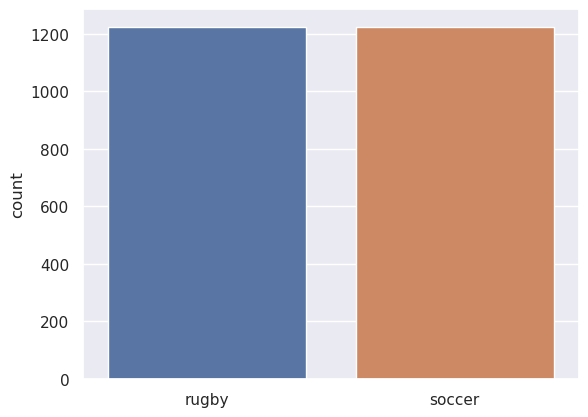

In [56]:
#Visualize how much data is in each training set

def display_counts(data):
    l = []
    for i in data:
        if(i[1] == 0):
            l.append("rugby")
        else:
            l.append("soccer")
    sns.set_theme(style="darkgrid")
    return sns.countplot(x=l)

#Create the list of dataframes to cycle count through
datasets = [train, test]

display_counts(train)

Text(0.5, 1.0, 'rugby')

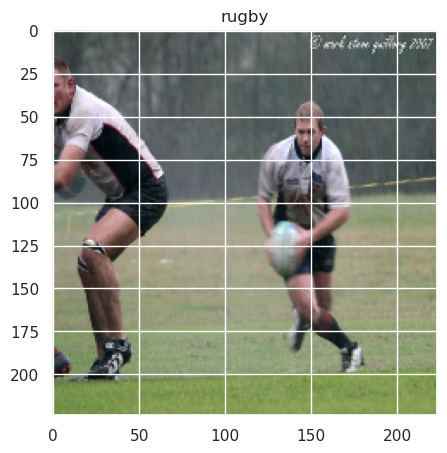

In [58]:
#Test for the rugby images
plt.figure(figsize = (5,5))
plt.imshow(train[1][0])
plt.title(labels[train[0][1]])

Text(0.5, 1.0, 'soccer')

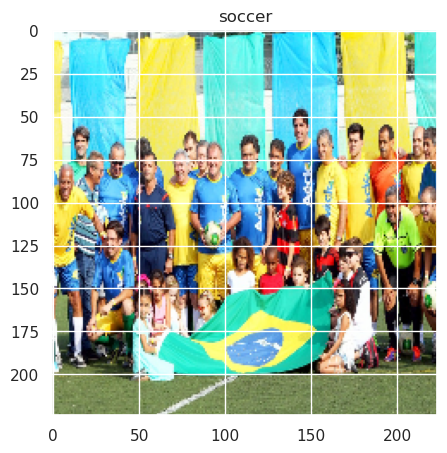

In [60]:
#Similarly test for the soccer images
plt.figure(figsize = (5,5))
plt.imshow(train[-1][0])
plt.title(labels[train[-1][1]])

In [61]:
#Pre-processing the images to split into training and testing buckets

x_train = []
y_train = []
x_val = []
y_val = []

for feature, label in train:
  x_train.append(feature)
  y_train.append(label)

for feature, label in test:
  x_val.append(feature)
  y_val.append(label)

# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255

x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

In [62]:
#Apply augmentation to the data model to make the training more robust

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [63]:
#Build the CNN Model layers

model = Sequential()
model.add(Conv2D(32,3,padding="same", activation="relu", input_shape=(224,224,3)))
model.add(MaxPool2D())

model.add(Conv2D(32, 3, padding="same", activation="relu"))
model.add(MaxPool2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(128,activation="relu"))
model.add(Dense(2, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 64)       0

In [66]:
#Define optimizer and loss function
opt = Adam(learning_rate=0.000001)
model.compile(optimizer = opt , 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) , 
              metrics = ['accuracy'])

In [ ]:
#Train the model over 500 epochs and then store the parameters in history

history = model.fit(x_train,y_train,epochs = 500 , validation_data = (x_val, y_val))